In [28]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from random import seed
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
tf.compat.v1.experimental.output_all_intermediates(True)

In [2]:
tf.random.set_seed(36)

## Dataset

In [3]:
BASE_DIR_PATH = '../../Datasets'
DATASET_FILE = os.path.join(BASE_DIR_PATH, 'compiled_data_2016_2017.csv')

In [4]:
df = pd.read_csv(DATASET_FILE)
df

,Unnamed: 0,index,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel_Sto_Nino,Waterlevel_Montalban,Discharge_Sto_Nino,Discharge_San_Jose,Cross_Section_Sto_Nino,Cross_Section_Montalban,Velocity_Sto_Nino,Velocity_Montalban,datetime,t,x
0,0,0,0,1,2,0,0,12.18,21.03,21.033407,14.842428,803.88,630.9,0.026165,0.023526,2016-01-01 00:00:00,0.0,14420
1,1,1,0,1,1,1,0,12.19,21.03,21.280072,14.842428,804.54,630.9,0.026450,0.023526,2016-01-01 01:00:00,3600.0,14420
2,2,2,1,1,1,0,1,12.19,21.03,21.280072,14.842428,804.54,630.9,0.026450,0.023526,2016-01-01 02:00:00,7200.0,14420
3,3,3,0,0,0,1,0,12.20,21.03,21.529056,14.842428,805.20,630.9,0.026738,0.023526,2016-01-01 03:00:00,10800.0,14420
4,4,4,1,1,1,0,0,12.20,21.03,21.529056,14.842428,805.20,630.9,0.026738,0.023526,2016-01-01 04:00:00,14400.0,14420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,17515,16059,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 19:00:00,63140400.0,14420
17516,17516,16424,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 20:00:00,63144000.0,14420
17517,17517,16789,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 21:00:00,63147600.0,14420
17518,17518,17154,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 22:00:00,63151200.0,14420


In [5]:
df = df[['Waterlevel_Sto_Nino']]
df.head()

,Waterlevel_Sto_Nino
0,12.18
1,12.19
2,12.19
3,12.20
4,12.20


In [6]:
# Splitting for time series: split into 50-25-25
n = len(df)
train_df = df[0:int(n*0.5)]
val_df = df[int(n*0.5):int(n*0.75)]
test_df = df[int(n*0.75):]

## Window Generator

In [7]:
BATCH_SIZE = 32

In [8]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None, batch_size=BATCH_SIZE):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
        self.batch_size = batch_size

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    # Creating tf datasets for more convenient use and integration into model in the future
    def make_dataset(self, data, shuffle=True):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=self.batch_size,)

        ds = ds.map(self.split_window)

        return ds
    
    # properties to access them as tf datasets
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df, False)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [9]:
window = WindowGenerator(
        input_width=6, label_width=1, shift=1,
        label_columns=['Waterlevel_Sto_Nino']
    )

window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Waterlevel_Sto_Nino']

In [10]:
for example_inputs, example_labels in window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [11]:
window.example

(<tf.Tensor: shape=(32, 6, 1), dtype=float32, numpy=
 array([[[11.89],
         [11.89],
         [11.89],
         [11.89],
         [11.89],
         [11.89]],
 
        [[11.31],
         [11.31],
         [11.31],
         [11.31],
         [11.31],
         [11.31]],
 
        [[11.9 ],
         [11.9 ],
         [11.9 ],
         [11.9 ],
         [11.9 ],
         [11.9 ]],
 
        [[13.03],
         [13.03],
         [13.02],
         [13.02],
         [13.01],
         [13.  ]],
 
        [[17.39],
         [17.26],
         [16.77],
         [16.37],
         [15.99],
         [15.66]],
 
        [[12.13],
         [12.14],
         [12.14],
         [12.14],
         [12.12],
         [12.11]],
 
        [[11.87],
         [11.87],
         [11.87],
         [11.87],
         [11.87],
         [11.87]],
 
        [[11.9 ],
         [11.9 ],
         [11.9 ],
         [11.9 ],
         [11.9 ],
         [11.9 ]],
 
        [[11.9 ],
         [11.9 ],
         [11.9 ],
     

## Metrics

In [12]:
def r_square(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.square(K.sum(xm * ym))
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = (x_square_sum * y_square_sum) + K.epsilon()
    
    r = r_num / r_den
    return r

In [13]:
def NSE(y_true, y_pred):
    '''
    This is the Nash-Sutcliffe Efficiency Coefficient
    '''
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)

    
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Training Loop

In [14]:
# For easy compiling and fitting of different models
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), 
        optimizer='adam', 
        metrics=[tf.keras.metrics.MeanSquaredError(), NSE, r_square]
    )

    history = model.fit(
        window.train, 
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping]
    )

    return history

## Models

In [15]:
# Dense Neural Network
dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1,-1])
])

# Convolution Neural Network
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=(6,), activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

# LSTM
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

## Training

In [16]:
dense_history = compile_and_fit(dense, window)

Epoch 1/20
274/274 [==============================] - 6s 12ms/step - loss: 2.5699 - mean_squared_error: 2.5699 - NSE: -6.9617 - r_square: 0.9413 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_NSE: 0.8541 - val_r_square: 0.8795
Epoch 2/20
274/274 [==============================] - 3s 9ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - NSE: 0.9346 - r_square: 0.9464 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_NSE: 0.8711 - val_r_square: 0.8889
Epoch 3/20
274/274 [==============================] - 2s 8ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - NSE: 0.9339 - r_square: 0.9451 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_NSE: 0.8409 - val_r_square: 0.8923
Epoch 4/20
274/274 [==============================] - 2s 9ms/step - loss: 0.0273 - mean_squared_error: 0.0273 - NSE: 0.9360 - r_square: 0.9474 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_NSE: 0.8472 - val_r_square: 0.8889


In [17]:
dense_history.history

{'loss': [2.5698728561401367,
  0.02891743741929531,
  0.0281574297696352,
  0.027257487177848816],
 'mean_squared_error': [2.5698728561401367,
  0.02891743741929531,
  0.0281574297696352,
  0.027257487177848816],
 'NSE': [-6.961652755737305,
  0.9345622658729553,
  0.9338537454605103,
  0.9360226988792419],
 'r_square': [0.9413199424743652,
  0.9463950991630554,
  0.9451232552528381,
  0.947352409362793],
 'val_loss': [0.010035503655672073,
  0.009826233610510826,
  0.010842646472156048,
  0.010496877133846283],
 'val_mean_squared_error': [0.010035503655672073,
  0.009826233610510826,
  0.010842646472156048,
  0.010496877133846283],
 'val_NSE': [0.8541247844696045,
  0.8711241483688354,
  0.8409463167190552,
  0.8471547961235046],
 'val_r_square': [0.8795366287231445,
  0.8888722658157349,
  0.8923184871673584,
  0.8889378905296326]}

In [18]:
conv_history = compile_and_fit(conv_model, window)

Epoch 1/20
274/274 [==============================] - 7s 14ms/step - loss: 6.5669 - mean_squared_error: 6.5669 - NSE: -15.2507 - r_square: 0.9471 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_NSE: 0.8720 - val_r_square: 0.8911
Epoch 2/20
274/274 [==============================] - 3s 11ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - NSE: 0.9387 - r_square: 0.9497 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_NSE: 0.8698 - val_r_square: 0.8907
Epoch 3/20
274/274 [==============================] - 3s 11ms/step - loss: 0.0256 - mean_squared_error: 0.0256 - NSE: 0.9409 - r_square: 0.9492 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_NSE: 0.8488 - val_r_square: 0.8945
Epoch 4/20
274/274 [==============================] - 3s 11ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - NSE: 0.9396 - r_square: 0.9490 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_NSE: 0.8659 - val_r_square: 0.8952


In [19]:
lstm_history = compile_and_fit(lstm_model, window)

Epoch 1/20
274/274 [==============================] - 20s 33ms/step - loss: 13.0301 - mean_squared_error: 13.0301 - NSE: -29.3034 - r_square: 0.7425 - val_loss: 0.3308 - val_mean_squared_error: 0.3308 - val_NSE: -4.6469 - val_r_square: 0.9708
Epoch 2/20
274/274 [==============================] - 5s 19ms/step - loss: 0.3686 - mean_squared_error: 0.3686 - NSE: 0.1579 - r_square: 0.9622 - val_loss: 0.0472 - val_mean_squared_error: 0.0472 - val_NSE: 0.1424 - val_r_square: 0.9313
Epoch 3/20
274/274 [==============================] - 5s 16ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - NSE: 0.9385 - r_square: 0.9640 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_NSE: 0.9029 - val_r_square: 0.9330
Epoch 4/20
274/274 [==============================] - 4s 16ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - NSE: 0.9569 - r_square: 0.9711 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_NSE: 0.9113 - val_r_square: 0.9388
Epoch 5/20
274/274 [==========================

## Predictions

In [20]:
def get_predictions(model, test_set):
    y_pred = []
    
    for x, _ in test_set:
        predictions = model(x)
        for y in predictions:
            y_pred.append(y)
    
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(-1)
    
    return y_pred

In [32]:
def plot_graph(true, pred):
    plt.plot(true, label='Observed Values')
    plt.plot(pred, label='Predicted Values', alpha=0.5)
    plt.legend()
    plt.show()

In [22]:
def calc_nse(true, pred):
    SS_res = np.sum(np.square(true-pred))
    SS_tot = np.sum(np.square(true-np.mean(true)))
    
    return 1 - SS_res/SS_tot

In [23]:
def calc_mse(true, pred):
    return np.mean(np.square(true-pred))

In [24]:
test_df

,Waterlevel_Sto_Nino
13140,11.89
13141,11.87
13142,11.85
13143,11.84
13144,11.84
...,...
17515,12.44
17516,12.44
17517,12.44
17518,12.44


In [25]:
test_vals = test_df.values
y_true = test_vals[6:]
y_true = y_true.reshape(-1)
y_true

array([12.63, 12.81, 12.8 , ..., 12.44, 12.44, 12.44])

DNN

In [26]:
dnn_pred = get_predictions(dense, window.test)
dnn_pred

array([11.888952, 11.974639, 12.095265, ..., 12.445394, 12.445394,
       12.445394], dtype=float32)

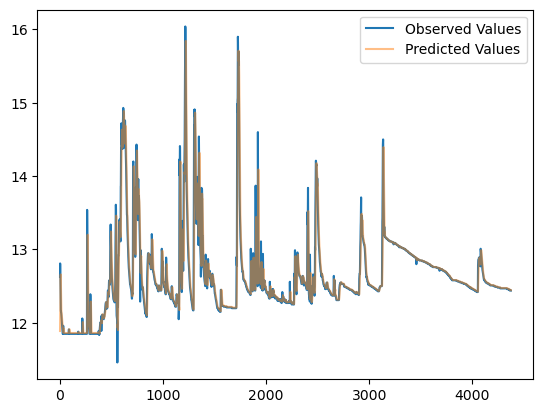

In [33]:
plot_graph(y_true, dnn_pred)

In [30]:
calc_nse(y_true, dnn_pred)

0.8511023823412354

In [31]:
calc_mse(y_true, dnn_pred)

0.046184885021909254

CNN

In [34]:
cnn_pred = get_predictions(conv_model, window.test)
cnn_pred

array([11.880107, 11.957189, 12.062867, ..., 12.421964, 12.421964,
       12.421964], dtype=float32)

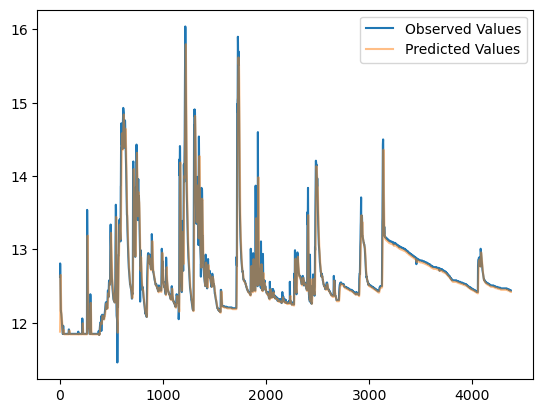

In [35]:
plot_graph(y_true, cnn_pred)

In [36]:
calc_nse(y_true, cnn_pred)

0.8617260239117328

In [37]:
calc_mse(y_true, cnn_pred)

0.04288965658130484

LSTM

In [38]:
lstm_pred = get_predictions(lstm_model, window.test)
lstm_pred

array([12.124246, 12.481522, 12.718819, ..., 12.447784, 12.447784,
       12.447784], dtype=float32)

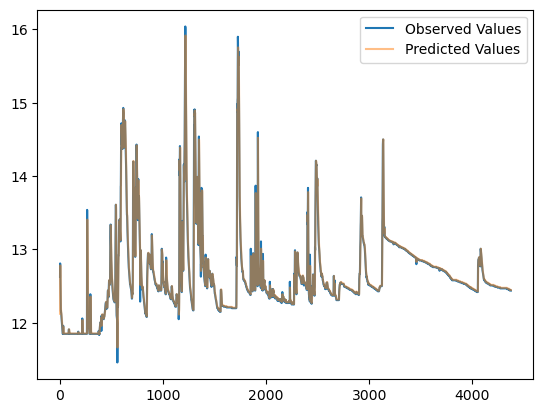

In [39]:
plot_graph(y_true, lstm_pred)

In [40]:
calc_nse(y_true, lstm_pred)

0.9693838353379521

In [41]:
calc_mse(y_true, lstm_pred)

0.009496485349880204

In [42]:
np.savetxt('../results/univariate_dnn_predictions.csv', dnn_pred, delimiter=',', fmt='%.4f')

In [43]:
np.savetxt('../results/univariate_cnn_predictions.csv', cnn_pred, delimiter=',', fmt='%.4f')

In [44]:
np.savetxt('../results/univariate_lstm_predictions.csv', lstm_pred, delimiter=',', fmt='%.4f')